# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [ ]:
# Запустите эту ячейку если работаете в Colab
!git clone https://github.com/balezz/tad_ml_dl_2021.git
%cd tad_ml_dl_2021/data
! wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat
%cd ../Assignment3

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("../data", max_train=10000, max_test=1000)    

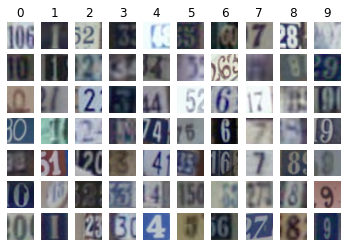

In [4]:
# Перед началом работы полезно посмотреть на данные.
# Отобразим пример из каждого класса.
classes = [str(i) for i in range(10)]
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(train_y == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(train_X[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [6]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

1.6159940625632276 1.6159940625648515
0.0 0.0
2.7625252407895857 2.7625252407403873
0.0 0.0
-0.5060347044691067 -0.506034704450542
-0.9430251923423104 -0.9430251923348009
Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [7]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

0.00041894809483629007 0.0004189480948355722
0.0017633776701492829 0.0017633776701851676
-0.0003499794108387513 -0.0003499794108165199
7.827474122159666e-05 7.82747412025886e-05
-0.000612293143427732 -0.0006122931434007078
-0.0010994667536866132 -0.001099466753707798
Gradient check passed!
-1.6742936540026396 -1.674293654002623
2.1531871835722116 2.1531871835723386
-0.15893915705062267 -0.1589391570506679
-0.5695817266487463 -0.569581726648713
3.3485873080052793 3.3485873080050728
-4.306374367144423 -4.306374367144504
0.31787831410124534 0.31787831410116235
1.1391634532974926 1.139163453297426
-0.36258121566049073 -0.36258121566042767
5.458420182865275 5.458420182865263
-3.3777345903380063 -3.377734590338105
-0.8933996664600199 -0.8933996664600706
Gradient check passed!
-0.632844000634635 -0.6328440006347219
-0.3900283198139658 -0.3900283198139675
1.7534099466422033 1.753409946642255
0.510813659702079 0.5108136597021216
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [8]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W1
1.0539358011190233e-05 1.0539369377227102e-05
0.0 0.0
-2.2352808274492203e-05 -2.235280849305354e-05
1.2557898252733468e-05 1.2557888062758591e-05
0.0 0.0
-4.999381612700218e-06 -4.999378688808065e-06
3.571409373914169e-05 3.5714098345351886e-05
0.0 0.0
4.390144384163224e-05 4.39014158359896e-05
7.981908270097966e-06 7.981904026621578e-06
0.0 0.0
-2.4729228476130488e-05 -2.4729218672803196e-05
6.989166757373945e-06 6.989164802462255e-06
0.0 0.0
-8.983331821326752e-06 -8.983325194833469e-06
3.217389652739876e-05 3.2173907982269156e-05
0.0 0.0
4.061184012563649e-05 4.0611869422946256e-05
3.011025496806162e-07 3.0109248427834245e-07
0.0 0.0
-2.9485151729063443e-05 -2.9485147656771456e-05
-1.2697558584257199e-06 -1.269739868803299e-06
0.0 0.0
-1.5467047488550946e-05 -1.5467027658644383e-05
2.585330555905679e-05 2.5853297280775674e-05
0.0 0.0
3.473865332469261e-05 3.473865639591622e-05
-1.77829884552218e-05 -1.7782997296933445e-05
0.0 0.0
-4.152676659387064e-05 -4.1

1.689000073125178e-05 1.6890000509306446e-05
-1.2756241549283164e-05 -1.2756262712798614e-05
0.0 0.0
7.506033808839767e-05 7.506031352022546e-05
-5.280800580620544e-05 -5.280798021090049e-05
0.0 0.0
-1.6923845691387064e-05 -1.692384010709702e-05
-4.178867751795621e-05 -4.1788705829048915e-05
0.0 0.0
2.1889820517425685e-05 2.1889778878403373e-05
-2.2167810350997953e-05 -2.2167800928230005e-05
0.0 0.0
7.464915226599838e-05 7.464917572974628e-05
-3.131184633410512e-05 -3.1311842008108215e-05
0.0 0.0
9.003692406114349e-06 9.003686685105095e-06
-2.7208138903857784e-05 -2.7208124642186245e-05
0.0 0.0
2.8294687322488472e-05 2.8294699916386886e-05
-5.153594363035923e-06 -5.153588666928499e-06
0.0 0.0
7.61718423913661e-05 7.617186881248017e-05
-3.382624481703079e-05 -3.382625290981878e-05
0.0 0.0
6.667276071597731e-06 6.667288943162929e-06
-3.0168425417795477e-05 -3.0168423315046763e-05
0.0 0.0
2.5543945221353617e-05 2.5543922532733628e-05
-6.103028360104796e-06 -6.10302919312744e-06
0.0 0.0
7.

0.0 0.0
0.00011696106113821479 0.00011696104085245905
-9.934205950708429e-05 -9.934204570072323e-05
0.0 0.0
1.4843672475606186e-05 1.4843681839238341e-05
-8.713497775691367e-05 -8.713498811374619e-05
0.0 0.0
3.2139661886815876e-05 3.2139646499729224e-05
-3.8556501808096197e-05 -3.8556513537457704e-05
0.0 0.0
9.871025897693692e-05 9.871026218633004e-05
-5.325696892708536e-05 -5.32569544020589e-05
0.0 0.0
-1.61504312498579e-05 -1.6150458748143137e-05
-4.1606990958192126e-05 -4.160698452437827e-05
0.0 0.0
-5.627085558921912e-07 -5.627276422615068e-07
3.518671582660684e-06 3.518674240865493e-06
0.0 0.0
6.994306890711838e-05 6.994307355512319e-05
-9.70370233927111e-06 -9.703704506591748e-06
0.0 0.0
-3.401937419734948e-05 -3.401936510272208e-05
4.042461890357523e-06 4.04245525942315e-06
0.0 0.0
-2.005563704544338e-05 -2.0055601623880648e-05
4.8407808461088175e-05 4.8407811092943114e-05
0.0 0.0
5.56966316861385e-05 5.56966250897517e-05
2.6029354454061155e-05 2.602933424356024e-05
0.0 0.0
-3.5

-4.770771300090375e-05 -4.770770445361449e-05
0.0 0.0
6.044187723206932e-05 6.0441873728223065e-05
-2.7795737326340958e-05 -2.7795721280199356e-05
0.0 0.0
8.489736826679305e-05 8.489735581207468e-05
-9.561735690321014e-06 -9.561751390663176e-06
0.0 0.0
0.00013636800401023138 0.0001363680057764327
-6.191616574084677e-05 -6.191616108708331e-05
0.0 0.0
6.033574627183457e-05 6.03357364070689e-05
-4.45867530413069e-05 -4.458673430463022e-05
0.0 0.0
8.358207914299207e-05 8.358209679926175e-05
-2.650778718618459e-05 -2.6507773753792204e-05
0.0 0.0
0.00013609925096836736 0.00013609922078217096
-7.174953436959948e-05 -7.174953964295128e-05
0.0 0.0
5.953261779894457e-05 5.9532623275515555e-05
-5.696655233912181e-05 -5.696654259423894e-05
0.0 0.0
8.160336718072669e-05 8.160334630247235e-05
-3.891705609524435e-05 -3.891704736247448e-05
0.0 0.0
0.00013290255777935784 0.00013290257783182824
-7.228331871936862e-05 -7.228333487319105e-05
0.0 0.0
6.260841035196532e-05 6.260840734739759e-05
-5.234674232

-5.774381680871332e-05 -5.77438319382395e-05
-2.3205140666821956e-05 -2.3205148913518766e-05
0.0 0.0
-2.7515548751279456e-05 -2.7515567602165444e-05
2.2240331220412738e-05 2.2240342900659012e-05
0.0 0.0
3.376261927825322e-05 3.376259272158677e-05
-4.9101241226555485e-05 -4.9101256394123986e-05
0.0 0.0
-4.324440578921277e-05 -4.324443025893742e-05
-3.784000586860698e-05 -3.784002000628561e-05
0.0 0.0
-1.2540139336681406e-05 -1.2540124494364589e-05
8.388332647790505e-06 8.388312267015863e-06
0.0 0.0
4.708428471254786e-05 4.708429202082697e-05
-6.434164287505403e-05 -6.43416431245214e-05
0.0 0.0
-5.019717270613415e-06 -5.019717974619198e-06
-5.253637286777308e-05 -5.253637525015619e-05
0.0 0.0
2.380887898639057e-05 2.3808865989849434e-05
-1.3060419188828599e-05 -1.306039720816443e-05
0.0 0.0
8.073067985385544e-05 8.073068880065648e-05
-6.953213831652139e-05 -6.953211340032794e-05
0.0 0.0
3.4209309647767826e-05 3.4209279853314456e-05
-5.9776415706961454e-05 -5.977642825172324e-05
0.0 0.0
6

0.0 0.0
2.4520274835897712e-05 2.452027469956874e-05
-1.6738226672213312e-05 -1.6738233021840188e-05
0.0 0.0
5.2310656462266374e-05 5.2310644704789404e-05
2.292325742883016e-05 2.292326328756644e-05
0.0 0.0
9.392708579362109e-05 9.392708832933748e-05
-1.3276956767108038e-05 -1.327693510688732e-05
0.0 0.0
4.600213873739493e-05 4.600213543426434e-05
5.678665958179701e-06 5.67865754419472e-06
0.0 0.0
7.552196057433104e-05 7.55219664583251e-05
4.953636644302939e-05 4.953637500193508e-05
0.0 0.0
0.00011746578347709527 0.00011746577044391414
-1.554534806051011e-05 -1.5545342790801442e-05
0.0 0.0
7.008746372827057e-05 7.008749136616643e-05
7.793559015618436e-06 7.793587997184659e-06
0.0 0.0
0.0001001085054639912 0.00010010852147246395
5.5801093278749515e-05 5.5801097076368926e-05
0.0 0.0
0.00014233662253370635 0.00014233663137019903
-3.829768174411858e-05 -3.829769834595709e-05
0.0 0.0
8.228239163500963e-05 8.228235870433309e-05
-1.3071438260859907e-05 -1.3071432825029204e-05
0.0 0.0
0.000111

1.1746976266719164e-05 1.1746958961111885e-05
-8.773410776640223e-05 -8.773408666229442e-05
0.0 0.0
3.753592953883488e-05 3.753592991984078e-05
-3.083982003920666e-05 -3.083981958695858e-05
0.0 0.0
9.159354251353987e-05 9.159357716725934e-05
-0.00011117884918552333 -0.00011117886611344828
0.0 0.0
-2.9491981480913604e-05 -2.9491964426142655e-05
-9.291486542328193e-05 -9.291487579332623e-05
0.0 0.0
-5.377231327654616e-06 -5.377209788548497e-06
-3.697154923809166e-05 -3.697155914750283e-05
0.0 0.0
5.1368517678198906e-05 5.1368509446092496e-05
-9.311141491741423e-05 -9.311140747314538e-05
0.0 0.0
-5.199317549236058e-05 -5.1993165328667594e-05
-7.538454685230035e-05 -7.5384543052337e-05
0.0 0.0
-3.075871645955023e-05 -3.075870669277947e-05
-2.00567611558955e-05 -2.0056756255826258e-05
0.0 0.0
3.0177463002672944e-05 3.017746053046721e-05
-7.284862274029135e-05 -7.284863823286969e-05
0.0 0.0
-3.792707920928452e-05 -3.792708369587672e-05
-5.302864350431175e-05 -5.302862593481449e-05
0.0 0.0
-1

-5.932642755612736e-05 -5.932641045092168e-05
0.0 0.0
2.4643045302569023e-05 2.464304316163179e-05
-3.54711616394865e-05 -3.547115934310341e-05
0.0 0.0
5.038150481658943e-05 5.038147676827975e-05
1.883492544806903e-07 1.8836043835790403e-07
0.0 0.0
9.3041631842324e-05 9.304164105827793e-05
-3.4606292613817495e-05 -3.460627340245992e-05
0.0 0.0
-5.963532173996692e-06 -5.9635185678530425e-06
-1.0866855082243156e-05 -1.086686296503103e-05
0.0 0.0
1.9667297888006542e-05 1.9667290018787753e-05
2.2040706636412113e-05 2.2040702596370917e-05
0.0 0.0
5.977027295528266e-05 5.9770277616166816e-05
-2.3772238490177895e-05 -2.3772250834497296e-05
0.0 0.0
-3.399549258944356e-05 -3.399547310323214e-05
1.0250299548671499e-09 1.021405182655144e-09
0.0 0.0
-8.333230917559987e-06 -8.333245204994455e-06
3.3095654715644574e-05 3.3095659546233946e-05
0.0 0.0
3.075297284986461e-05 3.0752977941972404e-05
-2.2189592237573866e-05 -2.2189605708433643e-05
0.0 0.0
-4.562144813569625e-05 -4.5621462163580866e-05
-8.4

8.374920983614694e-05 8.374920756892833e-05
-7.828205028141401e-05 -7.82820697153852e-05
0.0 0.0
4.27471285546929e-05 4.274713916174732e-05
-6.162095711341409e-05 -6.162093058037499e-05
0.0 0.0
6.894424189411571e-05 6.894422810432843e-05
-1.5315997607777455e-05 -1.531601512283487e-05
0.0 0.0
0.00010959030126646971 0.00010959029239643313
-9.880007491766647e-05 -9.880007922902222e-05
0.0 0.0
4.630283089636482e-05 4.630282823825382e-05
-8.70240182641408e-05 -8.702401022020466e-05
0.0 0.0
7.03418911632024e-05 7.034188787002904e-05
-3.812112033413685e-05 -3.81211284761207e-05
0.0 0.0
0.000113401993421749 0.00011340199890241819
-8.939824390053588e-05 -8.939824436282605e-05
0.0 0.0
3.598958957997321e-05 3.5989611291142865e-05
-7.991697306178932e-05 -7.991696193698772e-05
0.0 0.0
6.146809373994467e-05 6.14680750743446e-05
-3.0689140635623796e-05 -3.068914011805646e-05
0.0 0.0
0.00010244893469350382 0.00010244891601729476
-7.735132308104477e-05 -7.735132534492095e-05
0.0 0.0
3.1316547372478787e

0.0 0.0
-2.6185210822752028e-05 -2.618520955621761e-05
-2.8213180776059292e-05 -2.8213165137458415e-05
0.0 0.0
1.4264213620308704e-05 1.426423423822598e-05
-5.3894537559937755e-05 -5.389455548510113e-05
0.0 0.0
-6.793856744321183e-05 -6.793854367970198e-05
-5.543208249446223e-05 -5.543210335190451e-05
0.0 0.0
-5.1508312574877896e-05 -5.1508308729353296e-05
-2.1281159438754708e-05 -2.1281154616303862e-05
0.0 0.0
-9.059390098977426e-06 -9.059375472020292e-06
-4.630982839792666e-05 -4.6309822643308955e-05
0.0 0.0
-7.160612192711675e-05 -7.16060988281697e-05
-5.0000705013253285e-05 -5.00007146797543e-05
0.0 0.0
-5.717677476964186e-05 -5.7176752221721465e-05
-1.7713286418190283e-05 -1.7713297495447478e-05
0.0 0.0
-1.2887655374619317e-05 -1.2887646505532755e-05
-1.3680818569909563e-05 -1.3680789834324967e-05
0.0 0.0
-9.843544852953139e-05 -9.843545978327482e-05
4.257205666211283e-06 4.25721680130664e-06
0.0 0.0
-5.0811632254237584e-05 -5.081162157694052e-05
3.606824158905932e-05 3.6068237285

0.00010462476416541551 0.00010462475330541564
-8.075083493127878e-05 -8.075085045078367e-05
0.0 0.0
-2.5029772227588113e-05 -2.5029756045569226e-05
-4.64974088799377e-05 -4.649738372108913e-05
0.0 0.0
8.460307698113053e-07 8.460343536853542e-07
3.2352507997294026e-06 3.2352787115996757e-06
0.0 0.0
5.182074570683576e-05 5.18207698974038e-05
-6.198714906531714e-05 -6.198712654281735e-05
0.0 0.0
-7.307714673462367e-05 -7.307716654025853e-05
-3.0839051266737336e-05 -3.083906463530184e-05
0.0 0.0
-5.0086860771638525e-05 -5.0086867986465215e-05
2.045267897653801e-05 2.0452706195328574e-05
0.0 0.0
5.908358520689799e-06 5.908340483529172e-06
-5.656269053631433e-05 -5.656268786680129e-05
0.0 0.0
-7.16084523589598e-05 -7.160845250098191e-05
-2.600731630999346e-05 -2.6007307418751676e-05
0.0 0.0
-4.916893392366876e-05 -4.9168935589705136e-05
2.4640695120694774e-05 2.464071169328008e-05
0.0 0.0
9.799925189566312e-06 9.799916433905764e-06
-6.714612483562647e-05 -6.714611089364553e-05
0.0 0.0
-3.381

-2.4291416163070217e-05 -2.429141332527251e-05
0.0 0.0
-4.7129794968108585e-06 -4.7129855573757595e-06
2.036222008286586e-06 2.036237845004507e-06
0.0 0.0
1.7369856821499306e-05 1.736983890054944e-05
4.731973916242247e-05 4.7319748119889475e-05
0.0 0.0
6.063856970441896e-05 6.063858304372615e-05
-3.981575110947751e-05 -3.981575069644805e-05
0.0 0.0
7.054726194407824e-06 7.054712369836124e-06
-1.841671322573889e-05 -1.8416734803849977e-05
0.0 0.0
3.0510822218177896e-05 3.051079389138067e-05
2.9492930676564936e-05 2.9492941422404325e-05
0.0 0.0
7.14573804866197e-05 7.145739555625141e-05
-7.48663942093678e-05 -7.486640196674443e-05
0.0 0.0
2.8062042389546222e-05 2.806204157934644e-05
-5.576086085296311e-05 -5.576086259395651e-05
0.0 0.0
5.414937052495978e-05 5.4149373873713096e-05
-8.226121657196614e-06 -8.22613088757862e-06
0.0 0.0
8.998517127497471e-05 8.998517486702438e-05
-9.704906749473206e-05 -9.704905767904391e-05
0.0 0.0
5.86452715892785e-05 5.864526642085365e-05
-8.28239580179980

0.0 0.0
7.922541676810745e-05 7.92254262194092e-05
-3.4790029233488626e-05 -3.4790037517495875e-05
0.0 0.0
9.387593772299376e-05 9.387592925236275e-05
5.677384670733197e-06 5.67741409440714e-06
0.0 0.0
0.00014338483473495564 0.00014338485954112912
-3.934167475466076e-05 -3.934168546493311e-05
0.0 0.0
4.202257615883306e-05 4.202256320695596e-05
-3.7128891336390595e-05 -3.7128877750092215e-05
0.0 0.0
5.241291069582627e-05 5.2412918449817873e-05
4.497575190975172e-06 4.497557881677494e-06
0.0 0.0
0.00010657060946442003 0.00010657059679175517
-3.6768593306734435e-05 -3.676861037860135e-05
0.0 0.0
-2.5831738432233513e-05 -2.5831736749637454e-05
-3.9128724781229556e-05 -3.912870027988902e-05
0.0 0.0
-1.7309428931192264e-05 -1.730944276800983e-05
8.622295735326588e-06 8.622280667225368e-06
0.0 0.0
4.3729893799214024e-05 4.372990858314551e-05
-3.446458222235026e-05 -3.446458674005726e-05
0.0 0.0
-6.059934363047022e-05 -6.05993477620359e-05
-4.138737829004805e-05 -4.138738241010742e-05
0.0 0.0


0.0001272994385406939 0.00012729941545330803
-6.271338278939158e-05 -6.271339003660614e-05
0.0 0.0
3.697360545801452e-05 3.697362416232863e-05
-3.5108301034934614e-05 -3.510827184527443e-05
0.0 0.0
6.738704704921879e-05 6.738705149444968e-05
9.000531789219509e-06 9.000533651715159e-06
0.0 0.0
0.00010956422584352552 0.00010956422435981493
-3.3547180411414604e-05 -3.3547187250349e-05
0.0 0.0
-2.598194164692616e-06 -2.598188331148776e-06
-3.944571529520981e-06 -3.944577997572196e-06
0.0 0.0
2.609958635563122e-05 2.6099566952098027e-05
4.125719948559282e-05 4.125721986270037e-05
0.0 0.0
7.643592527802677e-05 7.643592425665702e-05
-4.046305752688764e-06 -4.046296631088353e-06
0.0 0.0
-4.185901134417869e-05 -4.185900515096818e-05
2.7569974478455418e-05 2.7569968530372076e-05
0.0 0.0
-1.3671292817336854e-05 -1.3671286325234176e-05
7.136642942341236e-05 7.136644608607412e-05
0.0 0.0
4.25027913487984e-05 4.2502801278487816e-05
1.76120647100057e-05 1.7612045155601663e-05
0.0 0.0
-6.9357637615390

0.0 0.0
-3.162043131509604e-05 -3.162041739557253e-05
-3.476645354445946e-06 -3.4766634016136773e-06
0.0 0.0
-6.802343270016161e-06 -6.802358676338826e-06
3.762987472755912e-05 3.7629899196645056e-05
0.0 0.0
6.473117796417447e-05 6.473115377048089e-05
-5.855252993907842e-05 -5.855254059383696e-05
0.0 0.0
7.503198029341656e-06 7.50317585840321e-06
-2.7224026868180063e-05 -2.7224023035898878e-05
0.0 0.0
3.304231449948147e-05 3.304230222767046e-05
1.3665955635545454e-05 1.3665957254715975e-05
0.0 0.0
9.961223529787333e-05 9.961222957599601e-05
-6.963669137206761e-05 -6.963669640924763e-05
0.0 0.0
4.6018133671309595e-05 4.601812264581894e-05
-3.865080456408022e-05 -3.865079367670887e-05
0.0 0.0
7.123888603227095e-05 7.123888146054469e-05
4.8394226814176374e-06 4.839417755420072e-06
0.0 0.0
0.00013308140701780968 0.00013308139035217437
-5.931002707682231e-05 -5.93100457635387e-05
0.0 0.0
7.82351780961909e-05 7.823519609928553e-05
-3.3525654782331994e-05 -3.352564892367127e-05
0.0 0.0
0.0001

8.137676741413718e-05 8.137677198760684e-05
-3.240862838740101e-05 -3.240863133413541e-05
0.0 0.0
0.00011513833271791692 0.00011513832109955045
-8.798882771055545e-05 -8.798881623306441e-05
0.0 0.0
7.182657118126522e-05 7.182656691639977e-05
-6.630021886414957e-05 -6.630020976672313e-05
0.0 0.0
0.00010031413134398498 0.00010031415698108502
-2.3691773638601556e-05 -2.3691781869672465e-05
0.0 0.0
0.00013276294435486205 0.00013276295618425138
-5.941253007245645e-05 -5.94125415531721e-05
0.0 0.0
6.504335689402955e-05 6.504334848500548e-05
-4.003741383753135e-05 -4.0037395621084215e-05
0.0 0.0
9.138118543546799e-05 9.138121370710904e-05
-1.4247916393191795e-07 -1.424638185199001e-07
0.0 0.0
0.00012368975948084135 0.00012368976953780475
-3.417629254712354e-05 -3.417630622948309e-05
0.0 0.0
4.563172823145089e-05 4.5631742828788895e-05
-1.705854853357081e-05 -1.7058532364444545e-05
0.0 0.0
6.987197304981863e-05 6.98719748726262e-05
2.0249723045179877e-05 2.0249735221966603e-05
0.0 0.0
0.000102

0.0 0.0
0.0001654804469692003 0.000165480429359377
1.2998148618985013e-05 1.2998135900943451e-05
0.0 0.0
0.00010494468725710618 0.00010494467517219162
2.4787274404453195e-05 2.478728333699109e-05
0.0 0.0
0.00011470872002831571 0.0001147087091979415
4.7328195659560736e-05 4.7328185814876626e-05
0.0 0.0
0.00016541901880281752 0.00016541901182165475
1.05772841195748e-05 1.0577294595748297e-05
0.0 0.0
7.173964577838709e-05 7.173963645357162e-05
2.0417315443043693e-05 2.0417312285303524e-05
0.0 0.0
7.731135583485653e-05 7.731135731603445e-05
4.914198616732219e-05 4.914200157912773e-05
0.0 0.0
0.00013495828388846462 0.00013495826678422418
5.69045380267667e-06 5.6904703171767315e-06
0.0 0.0
5.287654007775268e-06 5.287659199382232e-06
1.0976533287572277e-05 1.0976552999863996e-05
0.0 0.0
1.0199557406512875e-05 1.0199574518310328e-05
4.324934520575686e-05 4.3249337444706264e-05
0.0 0.0
6.876227558762209e-05 6.876226255059237e-05
-1.7674591537338675e-05 -1.7674572916348552e-05
0.0 0.0
-4.8569628

5.3908887979329545e-05 5.3908877362118794e-05
0.0 0.0
7.033309732004138e-05 7.033307269921352e-05
7.712427894571707e-05 7.712426253192461e-05
0.0 0.0
0.0001097641470738546 0.00010976415332208943
4.762494183192738e-05 4.762492622489844e-05
0.0 0.0
2.5828848140260162e-06 2.5828894578694417e-06
7.745664490906568e-05 7.74566188965764e-05
0.0 0.0
3.625593356472564e-05 3.625593159028995e-05
9.934154699210925e-05 9.93415349981319e-05
0.0 0.0
7.683186858432181e-05 7.683187419615933e-05
4.903871439922276e-05 4.90387286333771e-05
0.0 0.0
-3.301194320790646e-05 -3.301194873017721e-05
7.834175827637394e-05 7.834177750964955e-05
0.0 0.0
-1.0207300479581692e-06 -1.020739048840369e-06
9.876163629430502e-05 9.87616211034492e-05
0.0 0.0
4.5337468661573576e-05 4.533746711388175e-05
3.99777058425807e-05 3.997771003128037e-05
0.0 0.0
-5.333754291802037e-05 -5.3337512184725704e-05
6.868315725517887e-05 6.868317026231807e-05
0.0 0.0
-2.0711023905417873e-05 -2.071101068423786e-05
9.02718256808371e-05 9.02718

4.9241414073090525e-05 4.9241410948752666e-05
0.0 0.0
-4.249248613439808e-06 -4.249245399989832e-06
-2.7900802896863927e-05 -2.790079278724988e-05
0.0 0.0
-0.00010093349006577178 -0.00010093348379314192
-4.7912462734664056e-06 -4.791256280611833e-06
0.0 0.0
-6.755377128809572e-05 -6.755378478828789e-05
3.3270422323203486e-05 3.327043085477044e-05
0.0 0.0
-1.1946145079233377e-05 -1.194615517619013e-05
-3.947134104414178e-05 -3.9471359514209325e-05
0.0 0.0
-9.382604118286616e-05 -9.38260358296361e-05
-1.650656990207849e-05 -1.650655168106141e-05
0.0 0.0
-6.177145684743907e-05 -6.177147682251416e-05
2.8957608781861386e-05 2.8957614084390567e-05
0.0 0.0
-8.81008957575262e-06 -8.810108198531452e-06
-5.33066828799723e-05 -5.330669239356211e-05
0.0 0.0
-9.120427670692482e-05 -9.120428856590478e-05
-3.0292454042516137e-05 -3.0292457431357885e-05
0.0 0.0
-6.148493080241288e-05 -6.14849504643189e-05
1.746548542624452e-05 1.7465495716351143e-05
0.0 0.0
-1.2345155151341811e-05 -1.2345147126779919e

0.0 0.0
4.2170136299564284e-05 4.2170134051389134e-05
-4.072187759088521e-05 -4.072189252468661e-05
0.0 0.0
7.526740241793777e-05 7.526741452323904e-05
-1.4669203705321535e-05 -1.4669221393148744e-05
0.0 0.0
0.00010304772598296349 0.00010304772590785659
-3.505192438733708e-05 -3.505193912900495e-05
0.0 0.0
3.767449238502435e-05 3.7674485753314e-05
-8.138737853416052e-06 -8.138734131080128e-06
0.0 0.0
6.863561231042676e-05 6.863560830794313e-05
1.254508537827699e-05 1.2545076089054417e-05
0.0 0.0
9.499891316148775e-05 9.499894204623159e-05
-1.4454972444444011e-05 -1.4454992758317074e-05
0.0 0.0
1.276137317633405e-05 1.2761347534251398e-05
1.020161064057293e-05 1.0201617328675638e-05
0.0 0.0
4.162562373343675e-05 4.162563627119197e-05
2.8278526435779415e-05 2.8278535069148344e-05
0.0 0.0
7.032893806822621e-05 7.032894266956191e-05
-1.2044101984470718e-08 -1.2057022047429198e-08
0.0 0.0
-1.072657020309965e-05 -1.0726575183639396e-05
2.4909509226748576e-05 2.490949668754183e-05
0.0 0.0
1.8

2.7964280683663973e-05 2.796429754425844e-05
-2.955622627636749e-05 -2.955622413480796e-05
0.0 0.0
4.873416465385673e-05 4.8734172253261925e-05
-5.679178473155466e-06 -5.67919045124654e-06
0.0 0.0
9.35424262553171e-05 9.354241825576536e-05
-7.151992765937226e-05 -7.15199455214588e-05
0.0 0.0
7.359676158967048e-06 7.359668430240162e-06
-5.502488934430229e-05 -5.5024873546472e-05
0.0 0.0
3.102129361360887e-05 3.1021318847024304e-05
-2.5302608215005896e-05 -2.5302604456101104e-05
0.0 0.0
7.530804451374415e-05 7.530802648147983e-05
-2.4514872693550175e-05 -2.4514879015669063e-05
0.0 0.0
5.460926274469425e-05 5.460927265943382e-05
-7.131645921302381e-06 -7.131628620982155e-06
0.0 0.0
9.695516248537716e-05 9.695515501562112e-05
7.893499436360723e-06 7.893508069400923e-06
0.0 0.0
0.0001383004956553408 0.00013830048217755575
-2.2080426547219856e-05 -2.2080448580652497e-05
0.0 0.0
6.28243743192599e-05 6.282439013460817e-05
-5.121562176900202e-06 -5.12156983489831e-06
0.0 0.0
0.00010120415734520

-1.0252921271367768e-05 -1.0252954041334306e-05
-1.9492738422412144e-05 -1.9492740754856186e-05
0.0 0.0
-9.192999431870549e-05 -9.193001915264175e-05
6.741109507937525e-06 6.74109656984001e-06
0.0 0.0
-5.2075344873943157e-05 -5.207534403695035e-05
2.1673489654550248e-05 2.1673507433206393e-05
0.0 0.0
3.470961013820367e-06 3.4709346508066115e-06
1.2043076957157768e-05 1.2043077646239906e-05
0.0 0.0
-7.334182594227284e-05 -7.334186591378966e-05
3.7743653052715686e-05 3.774367485220864e-05
0.0 0.0
-3.279210296243005e-05 -3.2792080162380444e-05
5.1725574172303294e-05 5.1725557170811946e-05
0.0 0.0
2.425221756577076e-05 2.4252244656963736e-05
2.0031391664479547e-05 2.0031376557483327e-05
0.0 0.0
-5.639418450906296e-05 -5.6394178216123685e-05
4.509773047454552e-05 4.50977033494837e-05
0.0 0.0
-1.643380421449679e-05 -1.6433787664027477e-05
5.861095664659279e-05 5.8610960529392735e-05
0.0 0.0
4.374679090392137e-05 4.374678397311981e-05
1.7655115968171023e-05 1.765512180895712e-05
0.0 0.0
-3.00

-2.1795211961868956e-05 -2.1795210081165802e-05
0.0 0.0
0.000127381671809168 0.00012738166077497226
-6.942015379369201e-07 -6.942002528376178e-07
0.0 0.0
0.00016008561731823624 0.00016008563363811845
-4.801624701776537e-05 -4.8016257636618313e-05
0.0 0.0
9.111072115891793e-05 9.111071896938937e-05
-3.188509433719835e-05 -3.1885072360182676e-05
0.0 0.0
0.0001203871988252116 0.00012038718910645228
-7.979601952694744e-06 -7.979594762730358e-06
0.0 0.0
0.00015450651290812757 0.00015450651869031162
-5.078126532501887e-05 -5.078124587498677e-05
0.0 0.0
7.663544889710596e-05 7.663543133418216e-05
-3.44381877009761e-05 -3.443818563653167e-05
0.0 0.0
0.00010610885036167209 0.00010610885503581356
-1.2846444185443439e-05 -1.284643502685867e-05
0.0 0.0
0.00014045938995950192 0.00014045937746232084
-4.8080567647525e-05 -4.80805617542046e-05
0.0 0.0
6.485780567751074e-05 6.485780801313012e-05
-2.9026285788937528e-05 -2.902629248069388e-05
0.0 0.0
9.446930304326855e-05 9.44693212545644e-05
-1.5125342

-1.0008326018713556e-05 -1.0008349704548891e-05
1.5407994046365112e-05 1.540800820265531e-05
0.0 0.0
-6.664330223216467e-05 -6.664331309025329e-05
3.399229966996379e-05 3.399227566092122e-05
0.0 0.0
-3.270612324024927e-05 -3.270610449135347e-05
2.8346434670387394e-05 2.8346414104873926e-05
0.0 0.0
7.290365163242447e-06 7.290346104582567e-06
4.72641312873206e-06 4.726419255973724e-06
0.0 0.0
-3.4897868572315886e-05 -3.489786237764747e-05
2.6456279430879513e-05 2.6456259405449597e-05
0.0 0.0
-4.1898323414011247e-07 -4.189759650330415e-07
2.1956654179991852e-05 2.1956658713406792e-05
0.0 0.0
4.0642608131469344e-05 4.064260039626788e-05
-8.327855880361241e-06 -8.327849521094777e-06
0.0 0.0
7.739402048450052e-06 7.739409113582951e-06
1.1399614402056926e-05 1.1399592381167166e-05
0.0 0.0
4.035763132895001e-05 4.0357628350307095e-05
1.0544226903481638e-05 1.0544209949614468e-05
0.0 0.0
7.885251428663376e-05 7.885248010097712e-05
-2.6650522607604335e-05 -2.6650504025838014e-05
0.0 0.0
4.310000

0.0 0.0
-5.740746695347833e-05 -5.740745656623857e-05
-5.157463851122694e-05 -5.1574655657304895e-05
0.0 0.0
-2.530256353981079e-05 -2.530256004718012e-05
-2.282434203804049e-05 -2.2824320211611845e-05
0.0 0.0
3.4749371593917206e-05 3.474935894587361e-05
-6.142235755936934e-05 -6.142235609019053e-05
0.0 0.0
-8.445831036917267e-05 -8.445830701475641e-05
-4.9137373532516e-05 -4.913738305134529e-05
0.0 0.0
-5.161216385398883e-05 -5.161215899107673e-05
-2.4005945320222852e-05 -2.400595278118089e-05
0.0 0.0
1.2220651022301862e-05 1.2220646716798454e-05
-5.311372099068745e-05 -5.3113713427421765e-05
0.0 0.0
-0.00010054975467745679 -0.00010054976851137097
-3.881429684211662e-05 -3.881428511931517e-05
0.0 0.0
-6.583176054653227e-05 -6.583178446817328e-05
-1.4802201342157456e-05 -1.4802203907038345e-05
0.0 0.0
5.327466662717083e-07 5.327294161361351e-07
-3.724343843401257e-05 -3.724345276623353e-05
0.0 0.0
-0.00010723361021325576 -0.00010723359977760082
-2.349061150966584e-05 -2.349063166207088

0.0 0.0
2.7207074815928354e-06 2.7206903396859157e-06
-2.0979031859118896e-05 -2.0979040726842865e-05
0.0 0.0
-7.307092054458295e-05 -7.307090488239965e-05
-1.023261779674838e-05 -1.0232614755523173e-05
0.0 0.0
-3.927324078803789e-05 -3.927322911323472e-05
-4.4870686339191203e-07 -4.487077376325032e-07
0.0 0.0
6.7266406959172e-06 6.726619261598898e-06
-2.9974182241067317e-05 -2.9974156490197853e-05
0.0 0.0
-6.476098080929714e-05 -6.476099656538281e-05
-1.9432517912477166e-05 -1.9432522258000517e-05
0.0 0.0
-3.353475279428967e-05 -3.353477495693369e-05
-7.38636586545719e-06 -7.386358191752151e-06
0.0 0.0
1.2186041405158627e-05 1.2186074371811627e-05
-3.633013674290494e-05 -3.633013889725589e-05
0.0 0.0
-5.8761051657399226e-05 -5.8761062682322056e-05
-2.5879956337917942e-05 -2.587996483782717e-05
0.0 0.0
-3.000102711447748e-05 -3.0001046091854274e-05
-1.4136444385509071e-05 -1.4136425363631132e-05
0.0 0.0
1.662914705106255e-05 1.662914250744052e-05
-4.042103129869794e-05 -4.0421022085013

True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [9]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W1
-0.19763252622187344 -0.0197632526122149
Gradients are different at (0, 0). Analytic: -0.19763, Numeric: -0.01976


False

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [10]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться в некоторых эпохах. Не беспокойтесь пока про validation accuracy.

In [15]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.299050, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.097832, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.116604, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.124245, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.272042, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.334111, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.150439, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.290707, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.413618, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.141276, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.200819, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.422066, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278603, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.263215, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.161238, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.237810, Train acc

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [12]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.271417, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.394346, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.230423, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.280309, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.205645, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.227910, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.141015, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.368845, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.359281, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.365406, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.307300, Train accuracy: 0.209333, val accuracy: 0.215000
Loss: 2.365899, Train accuracy: 0.234667, val accuracy: 0.240000
Loss: 2.669171, Train accuracy: 0.249667, val accuracy: 0.248000
Loss: 2.262493, Train accuracy: 0.259667, val accuracy: 0.257000
Loss: 2.794106, Train accuracy: 0.274333, val accuracy: 0.275000
Loss: 2.528814, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [17]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.325434, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.325456, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297954, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.309233, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302456, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.308500, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.328091, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.325019, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.314374, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.368025, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.270798, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.276381, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.256681, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.315677, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.267261, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.213961, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [19]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.333167, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.323245, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.333705, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.296723, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.282242, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.330481, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.231158, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.225298, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.290215, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.995986, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.788104, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.930258, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.659276, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.978394, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.665922, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.556120, Train acc

Loss: 1.716324, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.717128, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.724081, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.727687, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.723835, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.719560, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.719585, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.717134, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.717590, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.729480, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.727687, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.707562, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.719586, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.713896, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.722975, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.719500, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [21]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.341743, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.323474, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.322151, Train accuracy: 0.200000, val accuracy: 0.000000
Loss: 2.296577, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.323358, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.262549, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.244965, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.321770, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.058183, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.018337, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.087892, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.868823, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.768826, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.989911, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.300364, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.388479, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [ ]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-4
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

print('best validation accuracy achieved: %f' % best_val_accuracy)

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [ ]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))